# Проект: "В один клик" - увеличение покупательской активности постоянных клиентов

**Цель исследования:** выделить факторы покупательской активности постоянных клиентов для того, чтобы воздействовать на эти факторы и увеличить выручку компании

**Задачи:**
1. Провести предобработку и исследовательский анализ данных
2. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца
3. Выделить факторы, которые наиболее значимы для предсказания покупательской активности
4. Выделить сегменты клиентов, которые интересны для работы 
5. Формулирование предложений для повышения покупательской активности интересного сегмента клиентов

**Представленные данные:** собственные исторические данные компании "В один клик"

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
import plotly.express as px

import phik
import numpy as np
import shap

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
pio.renderers.default='notebook'

RANDOM_STATE = 16
TEST_SIZE = 0.25

## Загрузка данных

**План работ:**
1. Загрузать данные из 4 файлов
2. Проверить соответствие даннных названию ппеременной (визуально)
3. Обработать названия переменных при необходимости
4. Поправить типы данных при необходимости

In [4]:
# Загрузка и проверка market_file
market_file = pd.read_csv('./market_file.csv')
market_file.head(10)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

In [5]:
#Информация о переменных в файле
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
# Загрузка и проверка market_money
market_money = pd.read_csv('./market_money.csv')
market_money.head(10)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

In [7]:
#Информация о переменных в файле
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
# Загрузка и проверка market_time
market_time = pd.read_csv('./market_time.csv')
market_time.head(10)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

In [9]:
#Информация о переменных в файле
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
# Загрузка и проверка money
money = pd.read_csv('./money.csv', sep = ';', decimal = ',')
money.head(10)

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

In [11]:
#Информация о переменных в файле
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [12]:
# Обработка названий переменных
df_list = [market_file, market_money, market_time, money]
for df in df_list:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
    print(df.columns.tolist())

['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
['id', 'период', 'выручка']
['id', 'период', 'минут']
['id', 'прибыль']


In [13]:
# Поправим тип переменной разрешить_сообщать
market_file['разрешить_сообщать'] = market_file['разрешить_сообщать'].str.lower().map({'да': True, 'нет': False})

In [14]:
# немного более понятное название столбца
market_file.rename(columns={
        'минут': 'минут_на_сайте'
    },
    inplace=True 
)

**Комментарий:** даненые из 4 файлов загружены, исправлены названия столбцов и бинарная переменная. 
Типы переменных соответствуют данным и не требуют корректировки.

## Предобработка данных

**План работ:***
1. Проверить явные дубликаты
2. Проверить пропуски
3. Стримировать и привести к единому регистру категориальные переменные, проверить на неявные дубликаты
4. Проверить уникальность id клиентов и их соответствие во всех 4х таблицах
5. Проверить количественные переменные (бе учета аномалий с точки зрения самого распределения)

In [15]:
# Проверка на дубликаты явные
for df in df_list:
    print(df.duplicated().sum())

0
0
0
0


In [16]:
# Проверка на дубликаты явные
for df in df_list:
    print(df.isna().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
id         0
период     0
выручка    0
dtype: int64
id        0
период    0
минут     0
dtype: int64
id         0
прибыль    0
dtype: int64


In [17]:
# Обработка категориальных переменных
for df in df_list:
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].str.lower().str.replace('  ', ' ')

In [18]:
# Поиск неявных дубликатов в категориальных переменных
for df in df_list:
    for column in df.select_dtypes(include=['object', 'bool']).columns:
        print(f"\n--- Столбец: {column} ---")
        print(f"Тип данных: {df[column].dtype}")
        print("Распределение значений:")
        print(df[column].unique())
        print(f"Количество уникальных значений: {df[column].nunique()}")


--- Столбец: покупательская_активность ---
Тип данных: object
Распределение значений:
['снизилась' 'прежний уровень']
Количество уникальных значений: 2

--- Столбец: тип_сервиса ---
Тип данных: object
Распределение значений:
['премиум' 'стандартт' 'стандарт']
Количество уникальных значений: 3

--- Столбец: разрешить_сообщать ---
Тип данных: bool
Распределение значений:
[ True False]
Количество уникальных значений: 2

--- Столбец: популярная_категория ---
Тип данных: object
Распределение значений:
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']
Количество уникальных значений: 6

--- Столбец: период ---
Тип данных: object
Распределение значений:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Количество уникальных значений: 3

--- Столбец: период ---
Тип данных: object
Распределение значений:
['текущий_месяц' 'предыдцщий_месяц']
Количество уникальных значений: 2


In [19]:
# Убираем неявный дубликат по типу сервиса
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')

In [20]:
# Исправление периодов
market_money['период'] = market_money['период'].str.replace('препредыдущий_месяц', 'предпредыдущий_месяц')
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [21]:
# Проверка исправлений
for df in df_list:
    for column in df.select_dtypes(include=['object', 'bool']).columns:
        print(f"\n--- Столбец: {column} ---")
        print(f"Тип данных: {df[column].dtype}")
        print("Распределение значений:")
        print(df[column].unique())
        print(f"Количество уникальных значений: {df[column].nunique()}")


--- Столбец: покупательская_активность ---
Тип данных: object
Распределение значений:
['снизилась' 'прежний уровень']
Количество уникальных значений: 2

--- Столбец: тип_сервиса ---
Тип данных: object
Распределение значений:
['премиум' 'стандарт']
Количество уникальных значений: 2

--- Столбец: разрешить_сообщать ---
Тип данных: bool
Распределение значений:
[ True False]
Количество уникальных значений: 2

--- Столбец: популярная_категория ---
Тип данных: object
Распределение значений:
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']
Количество уникальных значений: 6

--- Столбец: период ---
Тип данных: object
Распределение значений:
['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Количество уникальных значений: 3

--- Столбец: период ---
Тип данных: object
Распределение значений:
['текущий_месяц' 'предыдущий_месяц']
Количество уникальных значений: 2


In [22]:
# Проверка на дубликаты по id клиентов в market_file (если меньше 1300 получим уник., то есть дубликаты)
market_file['id'].nunique()

1300

In [23]:
# Проверка на дубликаты по id клиентов в market_file (если меньше 1300 получим уник., то есть дубликаты)
money['id'].nunique()

1300

In [24]:
# Проверка кол-ва уникальных id по периодам
display(market_money.pivot_table(index='период', values = 'id', aggfunc = 'nunique'))

id
период                    
предпредыдущий_месяц  1300
предыдущий_месяц      1300
текущий_месяц         1300

In [25]:
# Проверка кол-ва уникальных id по периодам
display(market_time.pivot_table(index='период', values = 'id', aggfunc = 'nunique'))

id
период                
предыдущий_месяц  1300
текущий_месяц     1300

In [26]:
# Проверка соответствия id между df
missing_ids = market_money[~market_money['id'].isin(market_file['id'])]['id']
print(f"id из market_money, которых нет в market_file: {missing_ids.tolist()}")

id из market_money, которых нет в market_file: []


In [27]:
# Проверка соответствия id между df
missing_ids = market_time[~market_time['id'].isin(market_file['id'])]['id']
print(f"id из market_time, которых нет в market_file: {missing_ids.tolist()}")

id из market_time, которых нет в market_file: []


In [28]:
# Проверка соответствия id между df
missing_ids = money[~money['id'].isin(market_file['id'])]['id']
print(f"id из money, которых нет в market_file: {missing_ids.tolist()}")

id из money, которых нет в market_file: []


In [29]:
# Анализ корректности количественных переменных
for df in df_list:
    display(df.select_dtypes(include=['float64', 'int64']).describe())

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

**Комментарий:** явные дубликаты и пропуски в данных отсутствуют. При этом:
- обработаны категориальные переменные (стриммированы, приведены к единому регистру)
- устранены неявные дубликаты и скорректированы написания для ряда категориальных переменных
- проведена проверка, что id клиентов не имеют дубликатов внутри датасетов или внутри одного периода датасета, все id клиентов присутствуют во всех файлах
- для количественных переменных видно, что некоторые принимают минимальное значение 0, но это значение по смыслу соответствуют переменной (0 акционных покупок или же 0 выручка)

## Исследовательский анализ даных

**План работ:**
- Изучить распределение по категориальным и количественным переменным, в том числе с помощью визуализации
- По количественным переменным проверить нет ли аномальных значений, а также определить наличие выбросов
- Зафиксировать рекомендации для последующих шагов с учетом результатов исследовательского анализа данных

In [30]:
# Функция для исследования количественных переменных
def quantitative_description(data):
    for column in data.select_dtypes(include=['float64', 'int64']).columns[1:]:
        col_name = column
        print(f'Описательная статистикка по переменной: {col_name}')
        display(data[column].describe())
        fig = px.histogram(data, x=column)
        fig.update_layout(
        xaxis_title=col_name,
        yaxis_title='Количество наблюдений',
        title = f'Гистограмма по переменной: {col_name}')
        fig.show()
        fig = px.box(data, x=column)
        fig.update_layout(
        xaxis_title=col_name,
        title = f'Диаграмма размаха по переменной: {col_name}')
        fig.show()

In [31]:
quantitative_description(market_file)

Описательная статистикка по переменной: маркет_актив_6_мес


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

Описательная статистикка по переменной: маркет_актив_тек_мес


count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

Описательная статистикка по переменной: длительность


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

Описательная статистикка по переменной: акционные_покупки


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

Описательная статистикка по переменной: средний_просмотр_категорий_за_визит


count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

Описательная статистикка по переменной: неоплаченные_продукты_штук_квартал


count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Описательная статистикка по переменной: ошибка_сервиса


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

Описательная статистикка по переменной: страниц_за_визит


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

In [32]:
# Функция для исследования категориальных переменных
def bar_plot(data):
    for column in data.select_dtypes(include=['object', 'bool']):
        col_name = column
        fig = px.bar(data[column].value_counts(normalize = True).round(2))
        fig.update_traces(texttemplate='%{y}', textposition='outside')
        fig.update_layout(
        xaxis_title=col_name,
        yaxis_title='Доля наблюдений',
        title= f'Распределение по переменной: {col_name}')
        fig.show() 


In [33]:
bar_plot(market_file)

In [34]:
# Разбиение переменной с выручкой по отдельным столбца
market_money_n3 = market_money.query('период == "предпредыдущий_месяц"')
market_money_n2 = market_money.query('период == "предыдущий_месяц"')
market_money_n1 = market_money.query('период == "текущий_месяц"')
market_money_new = market_money_n3.merge(market_money_n2, on='id', how = 'left').merge(market_money_n1, on='id', how = 'left')
market_money_new.head(10)

id              период_x  выручка_x          период_y  выручка_y  \
0  215348  предпредыдущий_месяц        0.0  предыдущий_месяц        0.0   
1  215349  предпредыдущий_месяц     4472.0  предыдущий_месяц     5216.0   
2  215350  предпредыдущий_месяц     4826.0  предыдущий_месяц     5457.5   
3  215351  предпредыдущий_месяц     4793.0  предыдущий_месяц     6158.0   
4  215352  предпредыдущий_месяц     4594.0  предыдущий_месяц     5807.5   
5  215353  предпредыдущий_месяц     5124.0  предыдущий_месяц     4738.5   
6  215354  предпредыдущий_месяц     4503.0  предыдущий_месяц     5685.0   
7  215355  предпредыдущий_месяц     4749.0  предыдущий_месяц     3263.0   
8  215356  предпредыдущий_месяц     4433.0  предыдущий_месяц     4146.5   
9  215357  предпредыдущий_месяц        0.0  предыдущий_месяц        0.0   

          период  выручка  
0  текущий_месяц   3293.1  
1  текущий_месяц   4971.6  
2  текущий_месяц   5058.4  
3  текущий_месяц   6610.4  
4  текущий_месяц   5872.5  
5  текущий_месяц   5388.5  
6  текущий_месяц   5869.6  
7  текущий_месяц   3772.6  
8  текущий_месяц   4566.4  
9  текущий_месяц   5986.3

In [35]:
market_money_new.rename(columns={'выручка_x': 'выручка_предпред_мес', 'выручка_y': 'выручка_пред_мес',\
                               'выручка': 'выручка_тек_мес'}, inplace = True)
cols_to_drop = ['период_x', 'период_y', 'период']
market_money_new.drop(cols_to_drop, axis=1, inplace = True)

In [36]:
# переменные с разностью выручки по периодам
market_money_new['разность_пред_тек_выручка'] = market_money_new['выручка_тек_мес'] - market_money_new['выручка_пред_мес']
market_money_new['разность_пред_пред_выручка'] = market_money_new['выручка_пред_мес'] - market_money_new['выручка_предпред_мес']

In [37]:
display(market_money_new.iloc[:, 1:].describe())

выручка_предпред_мес  выручка_пред_мес  выручка_тек_мес  \
count           1300.000000       1300.000000      1300.000000   
mean            4825.206923       4936.920385      5314.960846   
std              405.979663        739.597997      2939.708156   
min                0.000000          0.000000      2758.700000   
25%             4583.000000       4496.750000      4706.050000   
50%             4809.000000       5005.000000      5179.950000   
75%             5053.500000       5405.625000      5761.725000   
max             5663.000000       6869.500000    106862.200000   

       разность_пред_тек_выручка  разность_пред_пред_выручка  
count                1300.000000                 1300.000000  
mean                  378.040462                  111.713462  
std                  2831.850124                  669.622629  
min                 -2610.300000                -1999.000000  
25%                   -20.800000                 -337.875000  
50%                   289.250000                  104.250000  
75%                   617.825000                  577.875000  
max                100785.200000                 2067.000000

In [38]:
# Общая выручка
mm = market_money_new.query('выручка_тек_мес < 100000')
print('выручка за предпредыдущий месяц', mm['выручка_предпред_мес'].sum())
print('выручка за предыдущий месяц', mm['выручка_пред_мес'].sum())
print('выручка за текущий месяц', mm['выручка_тек_мес'].sum())

выручка за предпредыдущий месяц 6267718.0
выручка за предыдущий месяц 6411919.5
выручка за текущий месяц 6802586.899999999


In [39]:
# Общая сумма выручки за 3 месяца
market_money_new['выручка_3_мес'] = market_money_new['выручка_тек_мес'] + market_money_new['выручка_пред_мес'] \
+ market_money_new['выручка_предпред_мес']

сlients_buy = market_money_new.query('выручка_3_мес > 0')

In [40]:
# Посмортим наблюдение с очень большой выручкой за текущий месяц, которое сильно отличается
market_money_new[market_money_new['выручка_тек_мес'] > 106862]

id  выручка_предпред_мес  выручка_пред_мес  выручка_тек_мес  \
32  215380                5051.0            6077.0         106862.2   

    разность_пред_тек_выручка  разность_пред_пред_выручка  выручка_3_мес  
32                   100785.2                      1026.0       117990.2

In [41]:
market_file[market_file['id']== 215380]

id покупательская_активность тип_сервиса  разрешить_сообщать  \
32  215380                 снизилась     премиум               False   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
32                 1.7                     4           637               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  \
32  техника для красоты и здоровья                                    3   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
32                                   2               4                 7

Кажется, что по этому покупателю некорректные данные (в предыдущем и предпредыущем месяцах выручка сильно отличалась), и наблюдение следует удалить после объединения таблиц.

In [42]:
# Посморим распределение по вырчкам
fig = px.histogram(market_money.query('выручка < 100000'), x='выручка',
                  barmode = 'overlay', color = 'период')
fig.update_layout(
xaxis_title='Выручка',
yaxis_title='Количество наблюдений',
title = f'Гистограмма по выручке по периодам')
fig.show()

In [43]:
# Боксплот по выручкам
fig = px.box(market_money.query('выручка < 100000'), x='выручка',
                  color = 'период')
fig.update_layout(
xaxis_title='Выручка',
title = f'Боксплот по выручке по периодам')
fig.show()

In [44]:
# разбиение времени на сайте по периодам
market_time_n2 = market_time.query('период == "предыдущий_месяц"')
market_time_n1 = market_time.query('период == "текущий_месяц"')
market_time_new = market_time_n2.merge(market_time_n1, on='id', how = 'left')
market_time_new.head(10)

id          период_x  минут_x       период_y  минут_y
0  215348  предыдущий_месяц       13  текущий_месяц       14
1  215349  предыдущий_месяц       12  текущий_месяц       10
2  215350  предыдущий_месяц        8  текущий_месяц       13
3  215351  предыдущий_месяц       11  текущий_месяц       13
4  215352  предыдущий_месяц        8  текущий_месяц       11
5  215353  предыдущий_месяц       10  текущий_месяц       10
6  215354  предыдущий_месяц       11  текущий_месяц       12
7  215355  предыдущий_месяц       12  текущий_месяц       10
8  215356  предыдущий_месяц        6  текущий_месяц        7
9  215357  предыдущий_месяц       12  текущий_месяц        6

In [45]:
market_time_new.rename(columns={'минут_x': 'минут_пред_мес', 'минут_y': 'минут_тек_мес'}, inplace = True)
cols_to_drop_2 = ['период_x', 'период_y']
market_time_new.drop(cols_to_drop_2, axis=1, inplace = True)

In [46]:
display(market_time_new.iloc[:, 1:].describe())

минут_пред_мес  минут_тек_мес
count     1300.000000    1300.000000
mean        13.467692      13.204615
std          3.932029       4.220589
min          5.000000       4.000000
25%         11.000000      10.000000
50%         13.000000      13.000000
75%         17.000000      16.000000
max         23.000000      23.000000

In [47]:
# Распределения по времени на сайте
fig = px.histogram(market_time, x='минут',
                  barmode = 'overlay', color = 'период')
fig.update_layout(
xaxis_title='Минут на сайте',
yaxis_title='Количество наблюдений',
title = f'Гистограмма по минутам на сайте по периодам')
fig.show()


In [48]:
# боксплот по времени на сайте
fig = px.box(market_time, x='минут',
                  color = 'период')
fig.update_layout(
xaxis_title='минут на сайте',
title = f'Боксплот по минутам по периодам')
fig.show()

In [49]:
# Описательная статистика по в файлу с прибылью
quantitative_description(money)

Описательная статистикка по переменной: прибыль


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Теперь попробуем посмотреть сочетания различных переменных с покупательской активностью

In [50]:
# Сначала количественные переменные
cols = ['длительность', 'акционные_покупки', 'маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',\
       'ошибка_сервиса', 'страниц_за_визит']
for col in cols:
    fig = px.histogram(market_file, x=col,
                  barmode = 'overlay', color = 'покупательская_активность')
    fig.update_layout(
    xaxis_title= col,
    yaxis_title='Количество наблюдений',
    title = f'Гистограмма по покупательской активности и {col}')
    fig.show()

In [51]:
# теперь категориальные переменные
cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for col in cols:
    pivot_count = market_file.pivot_table(index = col, columns = 'покупательская_активность', values = 'id', aggfunc = 'count')
    pivot_percent = pivot_count.div(pivot_count.sum(axis=1), axis=0) * 100
    pivot_percent = pivot_percent.round(1)
    #display(pivot_percent)

    fig = px.bar(
    pivot_percent.reset_index(),  
    x=col,
    y=pivot_percent.columns,
    barmode='group',
    title= f'Распределение покупательской активности по {col} (%)',
    labels={'value': 'Доля, %'}
    )

    fig.show()


**Выводы на основании исследовательского анализа данных:** 

Все клиенты, в представленных датасетах, имели покупки в течение последних 3 месяцев. Часть клиентов не имела покупок в предпредыщущем и предыдущем месяце, но в текущем месяце все клиенты принесли выручку.

_Коммуникация с клиентом_: 
- В данных представлены 29% клиентов с Премиум сервисом и 71% клиентов со стандартным сервисом. Среди премиум клиентов больше доля тех, чья покупательская активность снизилась
- В данных представлено 26% клиентов, которые не разрешают рекламные рассылки. Доля снижения покупательской активности не отличается для тех, кто разрешает и не разрешает рассылки
- Длительность с момента регистрации на сайте: в данных представленны клиенты, которые зарегистрированы от 3 месяцев назади более (максимум почти 3 года). Средняя длительность с момента регистрации на сайте около 20 месяцев. 
- Маркетинговая активность за последние 6 месяцев - среднее значение и медиана составляет 4.2 акции на клиента. Есть небольшое количество выбросов - клиентом с очень низким количеством коммуникаций. При этом отсутствуют клиенты, которым не отправлялись маркетинговые коммуникации последние 6 месяцев. Также видно, что распределение по количеству маркетинговых коммуникаций за последние 6 месяцев у клиентов, у которых снизилась покупательская активность, сдвинуто чуть левее (меньше коммуникаций) по сравнению с клиентами, у которых покупательская активность не изменилась.
- За текущий месяц есть три варианта клиентов - с 3, 4 и 5 коммцникациями. 

_Поведение на сайте_: 
- Клиенты просматривали от 1 до 20 страниц за визит, в среднем 8 страниц. При этом покупатели, которые снизили покупательскую активность, просматривали меньше страниц за визит.
- Клиенты сталкиваются от 0 до 9 ошибок сервиса за визит, со средним и медианным значением в районе 4 ошибок. Тут отличий для тех, кто снизил и не снизил покупательскую активность по распределению не наблюдается.
- Время на сайте: в текущий месяц клиенты проводили на сайте от 4 до 23 минут, в среднем 13,2 минуты. В предыдущий месяц клиенты проводили на сайте от 5 до 23 минут, в среднем 13,5 минут. В целом существенного отличия времени на сайте в текущем и предыдущем месяце не наблюдается.

_Продуктовое поведение_:
- Категории продуктов в заказе: наиболее популярная категория товары для детей, наименее популярная - кухонная посуда. При этом доля покупателей со снижем покупательской активности по категориям товаров неравномерная, в частности, сравнительно высокая доля покупателей со снижением покупательской активности в товарх для детей.
- Клиенты просматривали от 1 до 6 категорий за визит со средним значением 3,3 категории. Распределение по клиентам, которые снизили активность, сдивнуто к 0 по сравнению с теми, кто активность не снизил.
- Число неоплаченных продуктов в корзине за последние 3 месяца составило от 0 до 10 товаров, в среднем 2,8 товаров. Распределение выглядит несимметричным, когда чаще не оплачивают небольшое количество категорий.
- Доля акционных покупок за 6 мес. отличается от 0 и до почти 100%, причем видно по распределению, что есть клиенты, которые ориентируются именно на акционные предложения (то есть с высокой долей акционных покупок, близкой к 1) и именно средних вероятно произошло снижение покупательской активности.

_Финансовое поведение_:
- За текущий месяц выручка составила в среднем 5314 на клиента, в предыдущем месяце - 4936 на клиента, в предпредыдущем месяце 4825 на клиента.Таким образом, сумма выручки на клиента за последние три месяца растет. Также выросла общая сумма выручки с 6267718 до 6802587. Однако также можно заметить, что разброс по выручке за эти 3 месяца также увеличился, то есть появились выбросы (клиенты с очень высокими и низкими значениями выручки). Кроме того, необходимо отметить, что есть клиенты как с увеличением выручки от месяца к месяцу (таких более 50%), так и со снижением выручки.


## Объединение таблиц

**План работ:**
- объединить таблицы и проверить результат объединения на коррекность
- построить распределения по выручки и времени с учетом переменной по покупательской активности (которые были в разных дф)

In [52]:
# Объединение таблиц
data = market_file.merge(market_money_new, on='id', how = 'left').merge(market_time_new, on='id', how = 'left')
data.head(10)

id покупательская_активность тип_сервиса  разрешить_сообщать  \
0  215348                 снизилась     премиум                True   
1  215349                 снизилась     премиум                True   
2  215350                 снизилась    стандарт               False   
3  215351                 снизилась    стандарт                True   
4  215352                 снизилась    стандарт               False   
5  215353                 снизилась    стандарт                True   
6  215354                 снизилась    стандарт                True   
7  215355                 снизилась    стандарт               False   
8  215356                 снизилась    стандарт                True   
9  215357                 снизилась    стандарт                True   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             популярная_категория  средний_просмотр_категорий_за_визит  ...  \
0                товары для детей                                    6  ...   
1                товары для детей                                    4  ...   
2               домашний текстиль                                    5  ...   
3                товары для детей                                    5  ...   
4                товары для детей                                    3  ...   
5               домашний текстиль                                    4  ...   
6           косметика и аксесуары                                    2  ...   
7                товары для детей                                    5  ...   
8           косметика и аксесуары                                    2  ...   
9  техника для красоты и здоровья                                    3  ...   

   ошибка_сервиса  страниц_за_визит  выручка_предпред_мес  выручка_пред_мес  \
0               1                 5                   0.0               0.0   
1               2                 5                4472.0            5216.0   
2               1                 5                4826.0            5457.5   
3               6                 4                4793.0            6158.0   
4               3                 2                4594.0            5807.5   
5               1                 4                5124.0            4738.5   
6               7                 2                4503.0            5685.0   
7               6                 4                4749.0            3263.0   
8               1                 3                4433.0            4146.5   
9               9                 5                   0.0               0.0   

   выручка_тек_мес  разность_пред_тек_выручка  разность_пред_пред_выручка  \
0           3293.1                     3293.1                         0.0   
1           4971.6                     -244.4                       744.0   
2           5058.4                     -399.1                       631.5   
3           6610.4                      452.4                      1365.0   
4           5872.5                       65.0                      1213.5   
5           5388.5                      650.0                      -385.5   
6           5869.6                      184.6                    

In [53]:
# Проверка результата объединения
data.shape

(1300, 21)

In [54]:
# подготовка к удалению аномального наблюдения по выручке
data[data['выручка_тек_мес'] > 106862]

id покупательская_активность тип_сервиса  разрешить_сообщать  \
32  215380                 снизилась     премиум               False   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
32                 1.7                     4           637               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  ...  \
32  техника для красоты и здоровья                                    3  ...   

    ошибка_сервиса  страниц_за_визит  выручка_предпред_мес  выручка_пред_мес  \
32               4                 7                5051.0            6077.0   

    выручка_тек_мес  разность_пред_тек_выручка  разность_пред_пред_выручка  \
32         106862.2                   100785.2                      1026.0   

    выручка_3_мес  минут_пред_мес  минут_тек_мес  
32       117990.2              12             14  

[1 rows x 21 columns]

In [55]:
# Удаление аномального наблюдения
data.drop(index=32, inplace = True)

In [56]:
# Дополнительно посмотрим распределения по выручке и переменной с покупательской активностью
cols_n = ['выручка_предпред_мес', 'выручка_пред_мес', 'выручка_тек_мес', 'разность_пред_тек_выручка',\
        'разность_пред_пред_выручка', 'выручка_3_мес']
for col in cols_n:
    fig = px.histogram(data, x=col,
                  barmode = 'overlay', color = 'покупательская_активность')
    fig.update_layout(
    xaxis_title= col,
    yaxis_title='Количество наблюдений',
    title = f'Гистограмма по покупательской активности и {col}')
    fig.show()

**Выводы:**
1. Таблицы успешно объединены в единый дф
2. Из дополнительно посроенных распределений можно увидеть следующее: разница в покупательской активности есть по распределению с выручкой за предпредыдущий месяц - клиенты со снижем активности приносили чуть меньше выручки 2 месяца назад
3. По иным переменным существенных отличий нет

In [57]:
# Отбор клиеентов, коорые что-то покупали все три месяца
data_ac = data.query('выручка_предпред_мес >0 and выручка_пред_мес >0 and выручка_тек_мес >0')
data_ac['id'].count()

np.int64(1296)

**Комментарий:** по итогам у нас выпало только 4 клиента, которые не делали покупки в предпредыдущий месяц.

## Корреляционный анализ

**План работ:**
- расчет корреляций Пирсона по количественным переменным
- расчет полной матрицы корреляций по всем переменным
- выделение переменных, имеющих высокую корреляцию с целевой переменной, а также переменных, коррелирующих с другими признаками
- определение способов решения проблем мультиколлинеарности

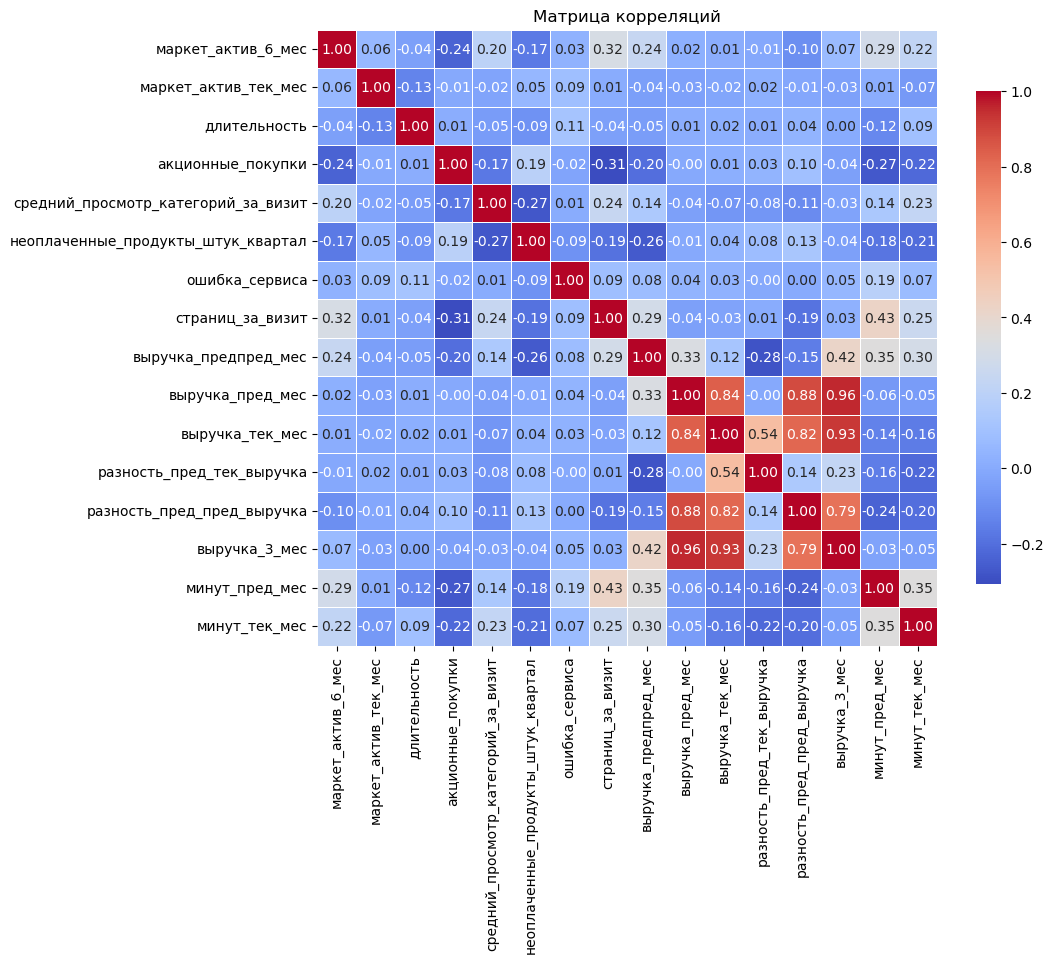

In [58]:
num_cols = data_ac.select_dtypes(include=['float64', 'int64']).columns[1:]

# Расчет корреляций для количественных переменных
corr = data_ac[num_cols].corr()

# Heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций")
plt.show()

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предпред_мес', 'выручка_пред_мес', 'выручка_тек_мес', 'разность_пред_тек_выручка', 'разность_пред_пред_выручка', 'выручка_3_мес', 'минут_пред_мес', 'минут_тек_мес']


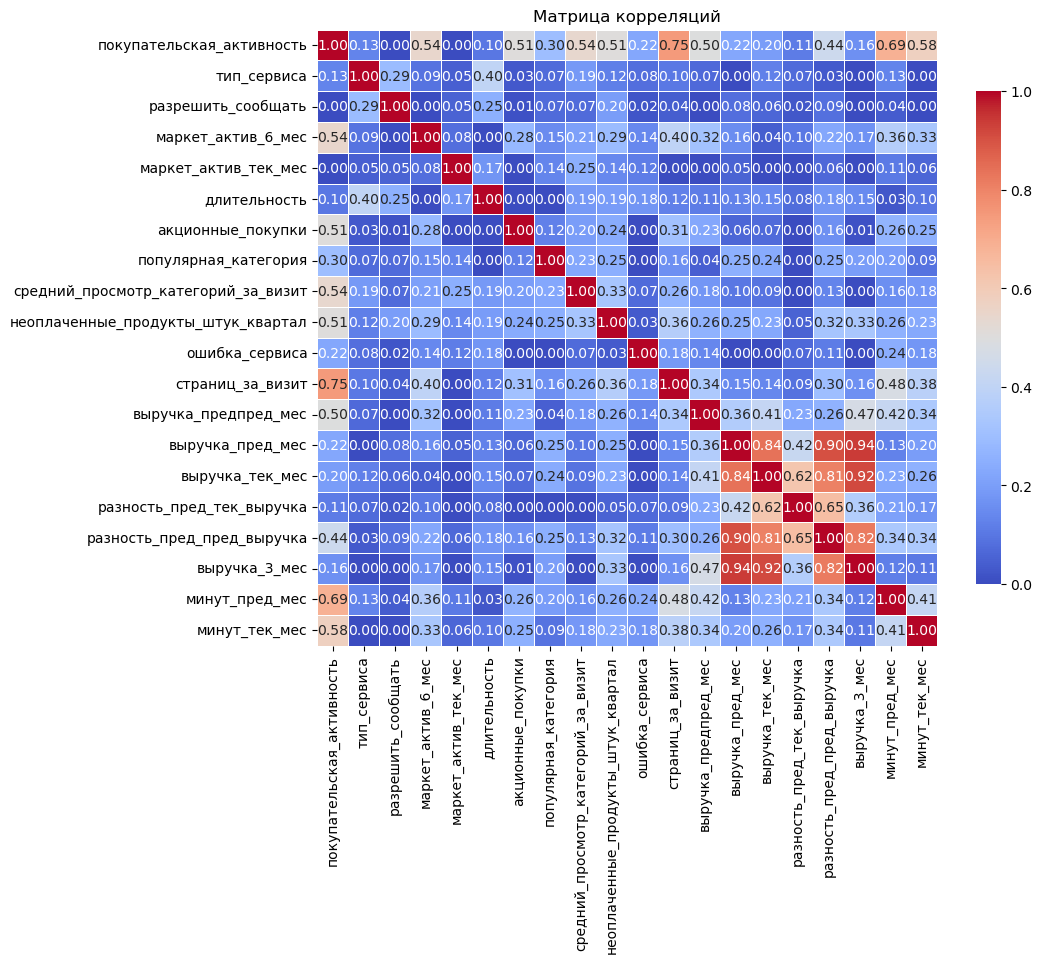

In [59]:
# Полная матрица корреляций
phik_matrix = data_ac.iloc[:, 1:].phik_matrix() 
plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций")
plt.show()

**Комментарий:** на основании матрицы корреляций мы видим, что есть корреляция покупательской активности и маркетинговой активности за полугодие, акционных покупок, среднего просмотра категорий за визит, количества неоплаченных товаров, просматриваемых за визит страниц, минут на сайте за текущий и предыдущий месяц, а также выручки в предпредыдущем месяце. Однако эти переменные также имеют зависимости с другими переменными, особенно акционные покупки, минуты на сайте и переменные по выручке. Для модели используем все переменные, кроме разности выручек по месяцам (дублирует информацию по выручке), переменной по маркетинговой активности в текущем месяце, потому что там очень небольшие отличия между клиентами, и по матрице корреляций также видно, что она мало связана с зависимой переменной.

In [60]:
#Убираем лишннее
data_model = data_ac.drop(['разность_пред_тек_выручка', 'разность_пред_пред_выручка', 'маркет_актив_тек_мес',\
                          'выручка_3_мес'], axis =1)
data_model.head(10)

id покупательская_активность тип_сервиса  разрешить_сообщать  \
1   215349                 снизилась     премиум                True   
2   215350                 снизилась    стандарт               False   
3   215351                 снизилась    стандарт                True   
4   215352                 снизилась    стандарт               False   
5   215353                 снизилась    стандарт                True   
6   215354                 снизилась    стандарт                True   
7   215355                 снизилась    стандарт               False   
8   215356                 снизилась    стандарт                True   
10  215358                 снизилась    стандарт                True   
12  215360                 снизилась     премиум                True   

    маркет_актив_6_мес  длительность  акционные_покупки  \
1                  4.4           819               0.75   
2                  4.9           539               0.14   
3                  3.2           896               0.99   
4                  5.1          1064               0.94   
5                  3.3           762               0.26   
6                  5.1           431               0.23   
7                  4.7           284               0.17   
8                  4.2           192               0.14   
10                 4.7           450               0.13   
12                 3.9           623               0.35   

     популярная_категория  средний_просмотр_категорий_за_визит  \
1        товары для детей                                    4   
2       домашний текстиль                                    5   
3        товары для детей                                    5   
4        товары для детей                                    3   
5       домашний текстиль                                    4   
6   косметика и аксесуары                                    2   
7        товары для детей                                    5   
8   косметика и аксесуары                                    2   
10      домашний текстиль                                    4   
12        кухонная посуда                                    3   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                    4               2                 5   
2                                    2               1                 5   
3                                    0               6                 4   
4                                    2               3                 2   
5                                    1               1                 4   
6                                    3               7                 2   
7                                    1               6                 4   
8                                    2               1                 3   
10                                   2               6                 4   
12                                   1               4                 7   

    выручка_предпред_мес  выручка_пред_мес  выручка_тек_мес  минут_пред_мес  \
1                 4472.0            5216.0           4971.6              12   
2                 4826.0            5457.5           5058.4               8   
3                 4793.0            6158.0           6610.4              11   
4                 4594.0            5807.5           5872.5               8   
5                 5124.0            4738.5           5388.5              10   
6                 4503.0            5685.0           5869.6              11   
7                 4749.0            3263.0           3772.6              12   
8                 4433.0            4146.5           4566.4               6   
10                4727.0            3488.0           4209.5              14   
12                5555.0            5304.5           5834.9               9   

    минут_тек_мес  
1              10  
2              13  
3              13  
4              11  
5              10  
6          

**Выводы:** данные подготовлены для моделирования

## Выбор модели и ее гиперпараметров

**План работ:** 
- Перевести зависимую переменную в 1 и 0, где 1 будет означать снижение покупательской активности
- Провести выбор оптимальной модели и ее гиперпараметров

**Целевая метрика качества:** поскольку у нас есть небольшой дисбаланс классов, а кроме того нам важны и ложноотрицательные (не выявили клиентов, у которых вероятность снижения покупательской активности и ничего им не предложили), и ложноположительные (избыточно предложили клиентам маркетинговые предложения и потеряли на этом) предсказания, то будем ориентироваться на метрику roc_auc_score

In [61]:
# Кодировка зависимой переменной 1 и 0
def typep(row):
    activity = row['покупательская_активность']
    if activity == 'снизилась':
        return 1
    else:
        return 0


data_model['покупательская_активность'] = data_model.apply(typep, axis=1)

In [62]:
# Подготовка пайплайна
X_train, X_test, y_train, y_test = train_test_split(
    data_model.drop(['покупательская_активность', 'id'], axis=1),
    data_model['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_model['покупательская_активность'])

print('Тренировочная выборка:', X_train.shape, 'Тестовая выборка', X_test.shape)

# создаём списки с названиями признаков
cat_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = ['маркет_актив_6_мес', 'длительность', 'средний_просмотр_категорий_за_визит', \
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'выручка_предпред_мес', 'выручка_пред_мес',\
               'выручка_тек_мес', 'страниц_за_визит', 'акционные_покупки', 'минут_пред_мес', 'минут_тек_мес']

# создаём пайплайны для категориальных переменных
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ])

ordinal_pipe = Pipeline([('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(transformers=
    [('cat', ohe_pipe, cat_columns),
     ('num', MinMaxScaler(), num_columns)
    ], remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])



param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3,6),
        'models__max_features': range(2,6),
        'preprocessor__cat': [ordinal_pipe, ohe_pipe], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
        # словарь для модели SVR
    {
       'models': [SVC(random_state=RANDOM_STATE, probability = True)],
       'models__kernel': ['linear', 'rbf'],
       'models__C': range(1,6),
       'preprocessor__cat': [ohe_pipe], 
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
        # словарь для модели Random Forest
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3,6),
        'models__max_features': range(2,6),
        'preprocessor__cat': [ordinal_pipe, ohe_pipe], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear' 
        )],
        'models__C': range(1,5),
        'models__penalty': ['l1', 'l2'],
        'preprocessor__cat': [ohe_pipe], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]



Тренировочная выборка: (972, 15) Тестовая выборка (324, 15)


In [63]:
# Подбор параметров и моделей
# Подбор делаем через случайный поиск, т.к. получается много параметров и поиск по гриду будет ресурсоемким
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter = 30,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', 'passthrough',
                                                  ['маркет_

In [64]:
feature_names = randomized_search.best_estimator_.named_steps.get('preprocessor', None).get_feature_names_out()

In [65]:
# Справочная информация о наилучших моделях
cv_results_df = (
    pd.DataFrame(randomized_search.cv_results_)
    .sort_values('rank_test_score')
    [[
        'param_models',
        'param_models__max_depth',  # для DecisionTree
        'param_models__max_features',  # для DecisionTree
        'param_models__C',  # для LogisticRegression
        'param_preprocessor__num',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]]
)

# Красивое отображение
pd.set_option('display.max_colwidth', None)
display(cv_results_df.head(10))

param_models  \
4   LogisticRegression(random_state=16, solver='liblinear')   
7                    SVC(probability=True, random_state=16)   
19  LogisticRegression(random_state=16, solver='liblinear')   
12                   SVC(probability=True, random_state=16)   
28                   SVC(probability=True, random_state=16)   
14  LogisticRegression(random_state=16, solver='liblinear')   
29  LogisticRegression(random_state=16, solver='liblinear')   
1                   DecisionTreeClassifier(random_state=16)   
8                   DecisionTreeClassifier(random_state=16)   
6                   DecisionTreeClassifier(random_state=16)   

    param_models__max_depth  param_models__max_features  param_models__C  \
4                       NaN                         NaN              3.0   
7                       NaN                         NaN              2.0   
19                      NaN                         NaN              2.0   
12                      NaN                         NaN              1.0   
28                      NaN                         NaN              4.0   
14                      NaN                         NaN              4.0   
29                      NaN                         NaN              3.0   
1                       4.0                         3.0              NaN   
8                       4.0                         3.0              NaN   
6                       4.0                         3.0              NaN   

   param_preprocessor__num  mean_test_score  std_test_score  rank_test_score  
4              passthrough         0.902669        0.032424                1  
7           MinMaxScaler()         0.898648        0.033478                2  
19             passthrough         0.898156        0.029713                3  
12        StandardScaler()         0.898058        0.034573                4  
28        StandardScaler()         0.897993        0.034092                5  
14             passthrough         0.897051        0.031495                6  
29             passthrough         0.896350        0.032767                7  
1              passthrough         0.851923        0.019416                8  
8           MinMaxScaler()         0.851923        0.019416                8  
6         StandardScaler()         0.851335        0.019214               10

**Выводы:** Наилучшие результаты по roc_auc показывает модель логистической регрессии. Значение метрики качества на тренировочной выборке составляет 90%, на тестовой выборке - 90%. Это очень хороший показатель, который говорит о том, что модель предсказывает целевую переменную значительно лучше, чем просто случайное предсказание. Значения метрики качества на тренировочной и тестовой выборке близки, модель не переобучается.

## Анализ важности признаков

**План работ:**

Поскольку в нашем учебном окруужении не реализован метод получения списка фичей из наилучшей модели пайплайна, то воспроизведем наилучшую модель отдельно.

Далее проведем анализ признаков следующими способами:
- отбор наилучших признаков через SelectKBEst
- анализ с помощью метода SHAP

Размерность тренировочных данных: (972, 19)
Количество фичей: 19
Размерность SHAP values: (50, 19)


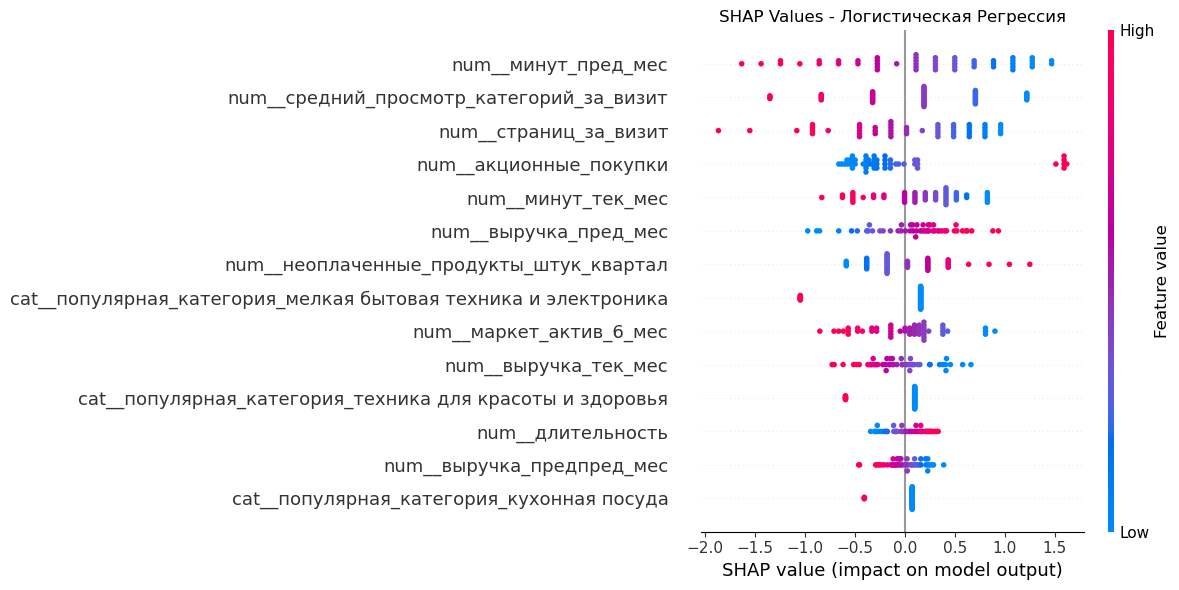

In [66]:
# Получаем наилучшую модель
best_pipeline = randomized_search.best_estimator_

# 1. ПРЕПРОЦЕССИМ ДАННЫЕ через пайплайн
X_train_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test.iloc[:50])

# 2. ПОЛУЧАЕМ ИМЕНА ФИЧЕЙ после препроцессинга
try:
    if hasattr(best_pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
        feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    else:
        # Создаем имена вручную
        feature_names = [f'feature_{i}' for i in range(X_train_preprocessed.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(X_train_preprocessed.shape[1])]

print(f"Размерность тренировочных данных: {X_train_preprocessed.shape}")
print(f"Количество фичей: {len(feature_names)}")

# 3. СОЗДАЕМ EXPLAINER с ПРЕПРОЦЕССИРОВАННЫМИ данными
explainer = shap.LinearExplainer(
    best_pipeline.named_steps['models'],  # модель логистической регрессии
    X_train_preprocessed,  # используем ПРЕПРОЦЕССИРОВАННЫЕ данные
    feature_names=feature_names
)

# 4. РАСЧЕТ SHAP VALUES на ПРЕПРОЦЕССИРОВАННЫХ данных
shap_values = explainer.shap_values(X_test_preprocessed)

print(f"Размерность SHAP values: {shap_values.shape}")

# 5. ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, 
                  X_test_preprocessed,
                  feature_names=feature_names, 
                  max_display=14, 
                  plot_size=(12, 6),
                  show=False)
plt.title("SHAP Values - Логистическая Регрессия")
plt.tight_layout()
plt.show()

**Выводы:**

Можно выделить следующие важные признаки:
- количество минут на сайте за 2 месяца: с ростом минут падает вероятность снижения активности
- просмотр страниц и категорий за визит - с ростом просмотров падает вероятность снижения активности
- акционные покупки: как и ранее было видно при исследовательском анализе данных - есть группа любителей акционных покупок и именно среди них снизислась активность
- выручка предпредыдущего месяца: высокая выручка снижает вероятность падения активности (вероятно речь идет о лояльных клиентах)
- с ростом неоплаченных продуктов за квартал растет вероятность снижения активности
- с ростом ошибок сервиса также растет вероятность снижения активности

А вот категории товара, которыми интересуются клиент, или тип сервиса/подписки не особо связаны с падением активности.

Вероятно, низкая активность на сайте (просмотры страниц за визит), время на сайте, низкие просмотры категорий за визит являются проявлениями падения покупательской активности, т.к. чем меньше смотрит клиент, тем меньше он покупает. А вот причиной снижения активности, вероятно, является интенсивность маркетингового воздействия на клиента, а также уровень цен и ассортимент магазина в сравнении с конкурентами, наличие интересных акций. На мой взгляд, наиболее интересно обратить внимание на переменную с количеством неоплаченного товара в корзине, т.к. увеличение оплаченных товаров точно повысит покупательскую активность клиентов, выручку и прибыль магазина. Вероятно, что клиенты кладут товар в корзину или для последующего сравнения и выбора (в том числе с другими магазинами), или спонтанно, но потом на итоговый чекаут не решаются по каким-то причинам. Также интересно, что покупательская активность снизилась у клиентов, у которых была низкая выручка в предпредыдущем месяце. То есть вероятно, что клиенты с низкой выручкой в текущем месяце также будут снижать далее свою покупательскую активность.

## Сегментация покупателей

Здесь предлагается исследовать сегмент клиентов с высокой вероятностью снижения покупательской активности и наличием значительного количества неоплаченных товаров в корзине. В частности, проверить как эта сегментаци выглядит для разных категорий товаров (проблема в какой-то конкретной категории или нет), типов подписки, какое покупательское поведение характерно для подобных клиентов, как они взаимодействуют с сайтом и какую интенсивность маркетингового воздействия получают.

**План работ:**
- получить предсказание вероятности падения активности для всего дф
- объединить дф data с данными по прибыльности покупателей
- с помощью диаграммы разброса уточнить границы сегмента
- посмотреть описательные характеристики сегмента
- предложить меры для повышения активности в выбранном сегменте

In [67]:
# воспроизведение наилучшей модели для анализа вероятности снижения на всем дф
X = data_model.drop(['покупательская_активность', 'id'], axis=1)
Y = data_model['покупательская_активность']

# Получаем наилучшую модель из randomized_search
best_pipeline = randomized_search.best_estimator_

# Используем трансформеры из пайплайна
preprocessor = best_pipeline.named_steps['preprocessor']
logit_model = best_pipeline.named_steps['models']

# Преобразуем данные через препроцессор из пайплайна
X_transformed = preprocessor.transform(X)

# Создаем DataFrame с правильными именами колонок
X_df = pd.DataFrame(X_transformed, columns=feature_names)

# Предсказание вероятностей через логистическую регрессию
y_proba = logit_model.predict_proba(X_df)[:, 1]
y_proba_series = pd.Series(y_proba)

print(f"Количество предсказаний: {y_proba_series.count()}")
print(f"Размерность преобразованных данных: {X_transformed.shape}")
print(f"Минимальная вероятность: {y_proba_series.min():.4f}")
print(f"Максимальная вероятность: {y_proba_series.max():.4f}")
print(f"Средняя вероятность: {y_proba_series.mean():.4f}")

Количество предсказаний: 1296
Размерность преобразованных данных: (1296, 19)
Минимальная вероятность: 0.0018
Максимальная вероятность: 0.9989
Средняя вероятность: 0.3803


In [68]:
data_rev = pd.concat([data_model.reset_index(drop=True), 
                     y_proba_series.reset_index(drop=True)], axis=1)
print(data_rev.shape)
data_rev = data_rev.rename(columns={0: 'вероятность_падения_активности'})
data_rev.head(10)

(1296, 18)


id  покупательская_активность тип_сервиса  разрешить_сообщать  \
0  215349                          1     премиум                True   
1  215350                          1    стандарт               False   
2  215351                          1    стандарт                True   
3  215352                          1    стандарт               False   
4  215353                          1    стандарт                True   
5  215354                          1    стандарт                True   
6  215355                          1    стандарт               False   
7  215356                          1    стандарт                True   
8  215358                          1    стандарт                True   
9  215360                          1     премиум                True   

   маркет_актив_6_мес  длительность  акционные_покупки   популярная_категория  \
0                 4.4           819               0.75       товары для детей   
1                 4.9           539               0.14      домашний текстиль   
2                 3.2           896               0.99       товары для детей   
3                 5.1          1064               0.94       товары для детей   
4                 3.3           762               0.26      домашний текстиль   
5                 5.1           431               0.23  косметика и аксесуары   
6                 4.7           284               0.17       товары для детей   
7                 4.2           192               0.14  косметика и аксесуары   
8                 4.7           450               0.13      домашний текстиль   
9                 3.9           623               0.35        кухонная посуда   

   средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
1                                    5                                   2   
2                                    5                                   0   
3                                    3                                   2   
4                                    4                                   1   
5                                    2                                   3   
6                                    5                                   1   
7                                    2                                   2   
8                                    4                                   2   
9                                    3                                   1   

   ошибка_сервиса  страниц_за_визит  выручка_предпред_мес  выручка_пред_мес  \
0               2                 5                4472.0            5216.0   
1               1                 5                4826.0            5457.5   
2               6                 4                4793.0            6158.0   
3               3                 2                4594.0            5807.5   
4               1                 4                5124.0            4738.5   
5               7                 2                4503.0            5685.0   
6               6                 4                4749.0            3263.0   
7               1                 3                4433.0            4146.5   
8               6                 4                4727.0            3488.0   
9               4                 7                5555.0            5304.5   

   выручка_тек_мес  минут_пред_мес  минут_тек_мес  \
0           4971.6              12             10   
1           5058.4               8             13   
2           6610.4              11             13   
3           5872.5               8             11   
4           5388.5              10             10   
5           5869.6              11             12   
6           3772.6              12             10   
7           4566.4               6              7   
8           4209.5              14             10   
9           5834.9               9              6   

   вероят

In [69]:
# Объединение таблиц
data_full = data_rev.merge(money, on='id', how = 'left')
print(data_full.shape)
display(data_full.head(10))

(1296, 19)


id  покупательская_активность тип_сервиса  разрешить_сообщать  \
0  215349                          1     премиум                True   
1  215350                          1    стандарт               False   
2  215351                          1    стандарт                True   
3  215352                          1    стандарт               False   
4  215353                          1    стандарт                True   
5  215354                          1    стандарт                True   
6  215355                          1    стандарт               False   
7  215356                          1    стандарт                True   
8  215358                          1    стандарт                True   
9  215360                          1     премиум                True   

   маркет_актив_6_мес  длительность  акционные_покупки   популярная_категория  \
0                 4.4           819               0.75       товары для детей   
1                 4.9           539               0.14      домашний текстиль   
2                 3.2           896               0.99       товары для детей   
3                 5.1          1064               0.94       товары для детей   
4                 3.3           762               0.26      домашний текстиль   
5                 5.1           431               0.23  косметика и аксесуары   
6                 4.7           284               0.17       товары для детей   
7                 4.2           192               0.14  косметика и аксесуары   
8                 4.7           450               0.13      домашний текстиль   
9                 3.9           623               0.35        кухонная посуда   

   средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
1                                    5                                   2   
2                                    5                                   0   
3                                    3                                   2   
4                                    4                                   1   
5                                    2                                   3   
6                                    5                                   1   
7                                    2                                   2   
8                                    4                                   2   
9                                    3                                   1   

   ошибка_сервиса  страниц_за_визит  выручка_предпред_мес  выручка_пред_мес  \
0               2                 5                4472.0            5216.0   
1               1                 5                4826.0            5457.5   
2               6                 4                4793.0            6158.0   
3               3                 2                4594.0            5807.5   
4               1                 4                5124.0            4738.5   
5               7                 2                4503.0            5685.0   
6               6                 4                4749.0            3263.0   
7               1                 3                4433.0            4146.5   
8               6                 4                4727.0            3488.0   
9               4                 7                5555.0            5304.5   

   выручка_тек_мес  минут_пред_мес  минут_тек_мес  \
0           4971.6              12             10   
1           5058.4               8             13   
2           6610.4              11             13   
3           5872.5               8             11   
4           5388.5              10             10   
5           5869.6              11             12   
6           3772.6              12             10   
7           4566.4               6              7   
8           4209.5              14             10   
9           5834.9               9              6   

   вероят

**Комментарий:** объединение прошло успешно, количество строк и столбцов совпадают с тем, что объединяли.

In [70]:
# Визуализация по зависимости переменных и покупательской активности
fig = px.scatter(
                data_full,
                x='вероятность_падения_активности',
                y='неоплаченные_продукты_штук_квартал',
                title='Вероятность падения активности и неоплаченные товары в корзине'
                #render_mode='webgl' 
            )

fig.update_layout(
                plot_bgcolor='white'
            )
fig.show()

Поскольку у нас неоплаченные товары - дискретная категория, то скэтер не очень интересно выглядит. попробуем другой вариант визуализации.

In [71]:
data_full['группа_вероятности'] = pd.cut(data_full['вероятность_падения_активности'], bins=100, labels = False)

In [72]:
bubble_data = data_full.groupby([
    'группа_вероятности',
    'неоплаченные_продукты_штук_квартал'
], as_index=False).agg(
    количество_клиентов=('id', 'count')  # Или 'nunique' для уникальных клиентов
)

fig = px.scatter(
    bubble_data,
    x='группа_вероятности',
    y='неоплаченные_продукты_штук_квартал',
    size='количество_клиентов',  # Размер пузырька = число клиентов
    size_max=50,                # Максимальный размер пузырька
    title='Распределение клиентов по вероятности падения активности и неоплаченным товарам')


# Настройка оформления
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    hoverlabel=dict(bgcolor='white')
)

fig.show()

**Комментарий:** на основании диаграммы виднно два основных скопления большинства точек. Нас интересуе скопление точек у высокой вероятности падения покупательской активности. Предлагаю определить границы целевого сегмента следующим образом - вероятность снижения покупательской активности более 60% и количество неоплаченных товаров в квартал более 4 (это чуть выше среднего по всему дф). Да, на графике видно также крупные пузырьки с менее, чем 4 неоплаченными товарами и высокой вероятностью падения активности, но по этим клиентам, вероятно, есть другие важные факторы, сопутствующие снижению покупательской активности. Далее посмотрим, что за клиенты в нашем целевом сегменте.

In [73]:
# Сделаем столбец с обозначением целевого сегмента
def type_cl(row):
    prob = row['группа_вероятности']
    unpaid = row['неоплаченные_продукты_штук_квартал']
    if prob >= 0.6 and unpaid >=4:
        return 1
    else:
        return 0


data_full['целевой_сегмент'] = data_full.apply(type_cl, axis=1)

In [74]:
data_full['целевой_сегмент'].value_counts()

целевой_сегмент
0    853
1    443
Name: count, dtype: int64

Итого у нас 443 клиента в целевой группе

In [75]:
# Посмотрим наш сегмент по категориям товаров
data_pivot = data_full.pivot_table(index = 'популярная_категория', columns = 'целевой_сегмент', values = 'id',\
                                   aggfunc = 'count')

data_pivot_percent = data_pivot.div(data_pivot.sum(axis=0)) * 100
print('Распределение целевого сегмента и прочих клиентов по категориям товаров (1=целевой ссегмент) в % от\
общего числа клиентов по категории')
display(data_pivot_percent.round(0))

Распределение целевого сегмента и прочих клиентов по категориям товаров (1=целевой ссегмент) в % отобщего числа клиентов по категории


целевой_сегмент                          0     1
популярная_категория                            
домашний текстиль                     17.0  24.0
косметика и аксесуары                 17.0  17.0
кухонная посуда                        9.0  14.0
мелкая бытовая техника и электроника  17.0   7.0
техника для красоты и здоровья        16.0  10.0
товары для детей                      24.0  28.0

In [76]:
# Посмотрим наш сегмент по типу сервиса
data_pivot = data_full.pivot_table(index = 'тип_сервиса', columns = 'целевой_сегмент', values = 'id',\
                                   aggfunc = 'count')

data_pivot_percent = data_pivot.div(data_pivot.sum(axis=0)) * 100
print('Распределение целевого сегмента и прочих клиентов по типам сервиса (1=целевой ссегмент) в % от\
общего числа клиентов по категории')
display(data_pivot_percent.round(0))

Распределение целевого сегмента и прочих клиентов по типам сервиса (1=целевой ссегмент) в % отобщего числа клиентов по категории


целевой_сегмент     0     1
тип_сервиса                
премиум          27.0  32.0
стандарт         73.0  68.0

In [77]:
# Посмотрим наш сегмент разрешению на рассылки
data_pivot = data_full.pivot_table(index = 'разрешить_сообщать', columns = 'целевой_сегмент', values = 'id',\
                                   aggfunc = 'count')

data_pivot_percent = data_pivot.div(data_pivot.sum(axis=0)) * 100
print('Распределение целевого сегмента и прочих клиентов по разрешению на рассылки (1=целевой ссегмент) в % от\
общего числа клиентов по категории')
display(data_pivot_percent.round(0))

Распределение целевого сегмента и прочих клиентов по разрешению на рассылки (1=целевой ссегмент) в % отобщего числа клиентов по категории


целевой_сегмент        0     1
разрешить_сообщать            
False               28.0  22.0
True                72.0  78.0

**Комментарий:** среди целевого сегмена представлены все категории товаров (но чуть выше доля домашнего текстиля, кухонной посуды, товаров для детей, а меньше доля техники. Скорее всего, большинство клиентов в этом сегменте - женщины.

Различия по категориям могут говорить о том, что у нас на сайе с товарами для техники все лучше, чем с домашними товарами и товарами для детей.
Также среди целевого сегмента у нас чуть больше доля клиентов с премиум подпиской. В задании дано мало подробностей о том, что дает премиум подписка, поэтому здесь сложно сделать выводы о причинах.

Хорошая новость также в том, что в целевом сегменте выше доля клиентов, которые не против рекламных рассылок.

In [78]:
# Посмотрим по взаимодействию с сайтом
data_pivot_site = data_full.pivot_table(index = 'целевой_сегмент', \
                                        values = ['минут_пред_мес', 'минут_тек_мес', 'средний_просмотр_категорий_за_визит',\
                                                  'страниц_за_визит', 'ошибка_сервиса'],  aggfunc = 'mean')
print('Среднее значение в сравнени по целевой и не целевой категории клиентов')
display(data_pivot_site.round(1))

Среднее значение в сравнени по целевой и не целевой категории клиентов


минут_пред_мес  минут_тек_мес  ошибка_сервиса  \
целевой_сегмент                                                  
0                          13.9           13.7             4.3   
1                          12.6           12.3             3.9   

                 средний_просмотр_категорий_за_визит  страниц_за_визит  
целевой_сегмент                                                         
0                                                3.5               8.6  
1                                                2.8               7.5

In [79]:
# Посмотрим по маркетинговой активности
data_pivot_mkg = data_full.pivot_table(index = 'целевой_сегмент', values = ['маркет_актив_6_мес', 'акционные_покупки'],\
                                   aggfunc = 'mean')
print('Среднее значение в сравнени по целевой и не целевой категории клиентов')
display(data_pivot_mkg.round(1))

Среднее значение в сравнени по целевой и не целевой категории клиентов


акционные_покупки  маркет_актив_6_мес
целевой_сегмент                                       
0                              0.3                 4.4
1                              0.4                 4.1

**Комсментарий:**  По данным переменным мы видим, что по маркетинговым коммуникациям наш целевой сегмент получает чуть меньше маркеинговых коммуникаций, а вот с сайтом они взаимодействуют меньше (меньше смотрят минут, страниц и категорий). Но хорошая новость в том, что это меньшая  активность на сайте не связана с ошибками сервиса. Вероятно, что проблема как раз в ассортименте и/или ценах на товары. При этом у интересующего нас сегмента выше доля акционных покупок на 10 п.п., то есть такой вид активности их привлекает.

In [81]:
# Смотрим, что с выручкой
data_target = data_full.query('целевой_сегмент ==1')
print('Динамика описательной статистики по выручке по целевому сегменту')
data_target[['выручка_предпред_мес', 'выручка_пред_мес', 'выручка_тек_мес']].describe()

Динамика описательной статистики по выручке по целевому сегменту


выручка_предпред_мес  выручка_пред_мес  выручка_тек_мес
count            443.000000        443.000000       443.000000
mean            4740.243792       4967.743792      5303.877652
std              323.243522        756.269698       906.521434
min             4098.000000       2890.000000      2758.700000
25%             4490.500000       4481.500000      4645.800000
50%             4727.000000       5022.000000      5258.000000
75%             4945.500000       5510.750000      5978.300000
max             5653.000000       6716.500000      7799.400000

**Комментарий:** средняя выручка растет, но растет и разброс значений по выручке. Эта динамике соответствуют динамике всех клиентов.

In [82]:
print('средняя прибыль по всем клиентам', data_full['прибыль'].mean().round(1))
print('средняя прибыль по клиенам нецелевой группы', data_full[data_full['целевой_сегмент']==0]['прибыль'].mean().round(1))

средняя прибыль по всем клиентам 4.0
средняя прибыль по клиенам нецелевой группы 4.0


In [83]:
data_target = data_full.query('целевой_сегмент ==1')
pivot_profit =data_target.pivot_table(index ='неоплаченные_продукты_штук_квартал', values = 'прибыль',\
                                      aggfunc = ['count', 'mean']).round(1)
print('Прибыльность в разрезе количества неоплаченных товаров')
display(pivot_profit)

Прибыльность в разрезе количества неоплаченных товаров


count    mean
                                   прибыль прибыль
неоплаченные_продукты_штук_квартал                
4                                      196     4.0
5                                      135     4.1
6                                       44     3.8
7                                       34     4.2
8                                       20     3.7
9                                       10     3.9
10                                       4     3.5

**Комментарий:** по прибыльности целевой сегмент немного отличается от остальных клиентов. Клиенты, которые не оплатили от 8 и более товаров по прибыльности ниже среднего, то есть они явно не докупили товары. Клиенты, которые не оплатили от 4 до 7 товаров по прибыльности соответствуют среднему, но вероятно могли бы ее увелчить.

**Предложения по повышению акивности целевого сегмента клиеннтов:**
1. Проверить полноту товаров и провести анализ цен товаров на сайте компании по категориям домашних товаров и товаров для детей
2. Клиентам, у которых более 4 неоплаченных товаров в корзине напоминать о том, что у них есть неоплаченный товар и:
- предлагать на него акции (снижение цены, несколько товаров со скидкой и т.п.)
- сообщать, что товар может скоро закончится
- предлагать более активно баннеры и рассылки с аналогичными товарами по акционным ценам, чтобы стимулировать посещение сайта и продажи
3. На детские товары также актуально предлагать клиенту восполнить запасы расходуемых товаров (подгузники, салфетки, смеси и прочее), а также следить за возрастной категорией ребенка, которая интересует клиента
4. На домашние товары интересно следить за стилистикой, которая инересует клиента, и предлагать именно подобные товары.
5. Изучить условия премиум подписки . Возможно, есть смысл сделать какие-то преференции для премиум клиентов.
6. Поскольку у нас, вероятно, в категории большая доля женщин, то есть смысл стимулировать эмоциональные покупки. Например - бери сейчас, платим потом или откажись на выгодных условиях, если товар не подошел.

## Общие выводы

Задачей данного исследования был поиск признаков, определяющих падение покупательской активности постоянных клиентов, с целью определения мероприятий для повышения выручки и прибыли компании "В один клик".

В качестве исходных данных были представлены собственные исторические данные компании о постоянных клиентах, снижении их активности, взаимодействии с сайтом, сервисом, покупательской активности и финансовых показателях этих клиентов. Представленные данные были проверены на предмет пропусков, явных и неявных дубликатов, и необходимые корректировки были проведены. В результате в анализ пошли данные о всех 1300 клиентах, которые были представлены в исторических данных.

В рамках исследовательского анализа данных были выявлены следующие интересные факты:
- В данных представленны клиенты, которые зарегистрированы достаточно давно (средняя длительность с момента регистрации 20 месяцев)
- Маркетинговая активность за последние 6 месяцев - среднее значение и медиана составляет 4.2 акции на клиента. Есть небольшое количество выбросов - клиентом с очень низким количеством коммуникаций. При этом отсутствуют клиенты, которым не отправлялись маркетинговые коммуникации последние 6 месяцев.
- Клиенты просмматривают в среднем 8 страниц за визит.
- Клиенты сталкиваются с 4 ошибками сервиса за визит.
- Клиенты проводят на сайте в текущем месяце в среднем 13,2 минуты. В предыдущий месяц клиенты проводили на сайте  в среднем 13,5 минут.
- Категории продуктов в заказе: наиболее популярная категория товары для детей, наименее популярная - кухонная посуда. При этом доля покупателей со снижем покупательской активности по категориям товаров неравномерная, в частности, сравнительно высокая доля покупателей со снижением покупательской активности в товарх для детей.
- Клиенты просматривали в среднем 3,3 категории за визитт на сайт.
- Число неоплаченных продуктов в корзине за последние 3 месяца составило  в среднем 2,8 товаров.
- Была выявлена группа клиентов с крайне высокой долей акционных покупок, близкой к 100%

За текущий месяц выручка составила в среднем 5314 у.е. на клиента, в предыдущем месяце - 4936 у.е. на клиента, в предпредыдущем месяце 4825 у.е. на клиента.Таким образом, сумма выручки на клиента за последние три месяца растет. Также выросла общая сумма выручки с 6267718 до 6802587. Однако также можно заметить, что разброс по выручке за эти 3 месяца также увеличился, то есть появились выбросы (клиенты с очень высокими и низкими значениями выручки). Кроме того, необходимо отметить, что есть клиенты как с увеличением выручки от месяца к месяцу (таких более 50%), так и со снижением выручки (менее 25%).

На основании исследовательского анализа данных можно было определить переменные, по которым есть видимое отличие покупательской активности: маркетинговые коммуникации за последние 6 месяцев, количество просматриваемых страниц за визит, число неоплаченных товаров в корзине, доля акционных покупок, количество минут на сайте, выручка за предпредыдущий месяц. Эти выводы нашли свое подтверждение также при построении марицы корреляций.

Ряд переменных был исключен при посроении модели:
- разность выручки по периодам
- исключена переменная по маркетинговой активности за текущий месяц в виду низкой дисперсии.

При построении модели использован случайный подбор наилучшей модели и гиперпараметров по 30 вариациям с использованием кросс-валидации. Подбиралась наилучшая модель из следующего списка: логистическая регрессия, метод опорных векторов, дерево решений. В качестве метрики качества была выбрана roc_auc_score, т.к. у нас есть небольшой дисбаланс классов, а также потому что нам важны и ложноотрицательные (не выявили клиентов, у которых вероятность снижения покупательской активности и ничего им не предложили), и ложноположительные (избыточно предложили клиентам маркетинговые предложения и потеряли на этом). В результате наилучшей моделью оказалась модель логистической регрессии. Ее метрика качества составила 90% тренировочной выборке, и 90% на тестовой выборке.

Анализ важности признаков в целом подтвердил выводы этапа исследовательского анализа данных. Были выделены следующие важные признаки:
На основании двух методов можно выделить следующие важные признаки:
- количество минут на сайте за 2 месяца: с ростом минут падает вероятность снижения активности
- просмотр страниц и категорий за визит - с ростом просмотров падает вероятность снижения активности
- акционные покупки: как и ранее было видно при исследовательском анализе данных - есть группа любителей акционных покупок и именно среди них высокая вероятнось снижения покупательской акивности (но не только среди них)
- выручка предпредыдущего месяца: высокая выручка снижает вероятность падения активности (вероятно речь идет о лояльных клиентах)
- с ростом неоплаченных продуктов за квартал растет вероятность снижения активности
- с ростом ошибок сервиса также растет вероятность снижения активности
А вот категории товара, которыми интересуются клиент, не особо оказывают влияние на падение активности, как и тип подписки (премиум или стандарт).

Вероятно, низкая активность на сайте (просмотры страниц за визит), время на сайте, низкие просмотры категорий за визит являются проявлениями падения покупательской активности, т.к. чем меньше смотрит клиент, тем меньше он покупает. А вот причиной снижения активности, вероятно, является интенсивность маркетингового воздействия на клиента, а также уровень цен и ассортимент магазина в сравнении с конкурентами, наличие интересных акций. На мой взгляд, наиболее интересно обратить внимание на переменную с количеством неоплаченного товара в корзине, т.к. увеличение оплаченных товаров точно повысит покупательскую активность клиентов, выручку и прибыль магазина. Именно на основании переменной по неоплаченным товарам и вероятности снижения покупаельской активности был выделен целевой сегмент клиентов.

Относительно целевого сегмента мы выяснили, что там чуть выше доля клиентов, популярной категорией которых являются товары для дома (текстиль, посуда) и товары для детей. Вероятнее всего, что это преимущественно женщины, поэтому есть смысл работать со стимулированием эмоциональных покупок (рассрочка?) Эти клиенты меньше по времени и по просматриваемым страницам взаимодействуют с сайтом, при этом у них на 10 п.п. выше доля акционных покупок. Также среди данных клиентов немного выше доля тех, у кого есть премиум-подписка.

**Мероприятия по повышению активности клиентов:**
- Проверить полноту товаров и провести анализ цен товаров на сайте компании по категориям домашних товаров и товаров для детей
- Клиентам, у которых более 4 неоплаченных товаров в корзине напоминать о том, что у них есть неоплаченный товар и:
  - предлагать на него акции (снижение цены, несколько товаров со скидкой и т.п.)
  - сообщать, что товар может скоро закончится
  - предлагать более активно баннеры и рассылки с аналогичными товарами по акционным ценам, чтобы стимулировать посещение сайта и продажи
- На детские товары также актуально предлагать клиенту восполнить запасы расходуемых товаров (подгузники, салфетки, смеси и прочее), а также следить за возрастной категорией ребенка, которая интересует клиента
- На домашние товары интересно следить за стилистикой, которая инересует клиента, и предлагать именно подобные товары.
- Изучить условия премиум подписки и, возможно, их скорректировать, чтобы заинтересовать премиум клиентов больше взаимодействовать с сайтом.
- Стимулировать эмоциональные покупки, предалагя разные финансовые инструменты, чтобы получить товар в руки было проще и быстрее.

Также рекомендуется посмотреть ошибки сервиса при посещении сайта, т.к. получается, что в среднем каждый клиент сталкивается с более, чем 1 ошибкой при посещении сайта, что кажется очень высоким показателем.